**The images of the curves of the functions below are taken from 
https://www.sfu.ca/~ssurjano/**  

**The implementations were made by Pascal Pascal Tikeng**

# **0) Workspace**

*Once this cell is successfully executed you can comment on it and execute all the notebook cells at once*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGvoGFH7hT29M4OCtj9vp7EE9FBnfNKARD4YCvX5J08I0CBmJtKqO0
Mounted at /content/drive


In [ ]:
! cp /content/drive/"My Drive"/"Pascal Notsawo Summer 2020 WL Research Internship"/"Project 2: Learning with Derivatives"/"week 1"/utils.py /content
! cp /content/drive/"My Drive"/"Pascal Notsawo Summer 2020 WL Research Internship"/"Project 2: Learning with Derivatives"/"week 2"/functions.py /content
! cp /content/drive/"My Drive"/"Pascal Notsawo Summer 2020 WL Research Internship"/"Project 2: Learning with Derivatives"/"week 3"/twin_net.py /content
! cp /content/drive/"My Drive"/"Pascal Notsawo Summer 2020 WL Research Internship"/"Project 2: Learning with Derivatives"/"week 2"/diff_ml_utils.py /content

In [ ]:
try:
    %tensorflow_version 1.x
    %matplotlib inline
except Exception:
    pass

import tensorflow as tf
import torch
import numpy as np
import random

from utils import gradient, genData, plotFunction, plotGrad, get_data_loader, MLP_Relu, train, plot_stat
from diff_ml_utils import graph, Generator, get_diffML_data_loader, BlackScholes, Bachelier

# to avoid collision
from utils import Siren as tf_Siren
from utils import test
from diff_ml_utils import test as diff_ml_test 

from functions import * # Styblinski-Tang, Ackley, Beale, Booth, Bukin, McCormick, Rosenbrock 
from twin_net import Siren, MLP, TwinNet

TensorFlow 1.x selected.
1.15.2
False




In [ ]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_random_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
nTrain = 20 
nTest = 10

HIDDEN_DIM = 256 
INPUT_DIM = 2
N_HIDDEN = 2 # Number of hidden layers (except input and output layers)
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features" : 1}
generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN}
siren_model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                      "out_features": 1, "outermost_linear" : False, 
                      "first_omega_0" : 30, "hidden_omega_0" : 30.}

max_epoch = 2
improving_limit = 1

batch_size = 512
learning_rate = 0.0001

train_seed, test_seed = 0, 0

**To avoid repeating the same code too much**

In [ ]:
def run_train(model_class, model_kwargs,  with_derivative, name_function, name_grad):
    global x_train, y_train, dydx_train, x_test, y_test, dydx_test 
    global batch_size, learning_rate, max_epoch, improving_limit
    global min_x, max_x, step_x, min_y, max_y, step_y

    if with_derivative :
        train_dataloader = get_data_loader(x = x_train, y = y_train,  dydx = dydx_train, batch_size = batch_size)
        test_dataloader = get_data_loader(x = x_test, y = y_test,  dydx = dydx_test, batch_size = batch_size)
    else :
        train_dataloader = get_data_loader(x = x_train, y = y_train,  dydx = None, batch_size = batch_size)
        test_dataloader = get_data_loader(x = x_test, y = y_test,  dydx = None, batch_size = batch_size)

    model = model_class(**model_kwargs)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    model, stats, best_loss = train(model, train_dataloader, optimizer, criterion, with_derivative = with_derivative, max_epoch = max_epoch, improving_limit = improving_limit)

    plot_stat(stats, with_derivative = with_derivative)

    test_loss = test(model, test_dataloader, criterion, with_derivative = with_derivative)

    plotFunction(name = name_function, model = model, 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)

    plotGrad(name = name_grad, model = model, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

    return model, test_loss

def run_diffML_train(name, generator, generator_kwargs, name_function, name_grad):
    global nTrain, nTest, train_seed, test_seed
    global min_x, max_x, step_x, min_y, max_y, step_y
  
    loss, regressor, dtrain, dtest, dydxTest, values, deltas = diff_ml_test(
          generator, [nTrain], 
          nTrain, nTest, 
          trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
          deltidx=0,
          generator_kwargs = generator_kwargs 
      ) 
    
    plotFunction(name = name_function, function =  lambda x : regressor.predict_values([x])[0][0], 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)

    plotGrad(name = name_grad, 
            deriv_function = lambda index : lambda x : regressor.predict_values_and_derivs([x])[1][0][index], 
            min_x = min_x, max_x = max_x, step_x = step_x, 
            min_y = min_y, max_y = max_y, step_y = step_y)

    show_graph_per_axis = True 
    input_dim = 2
    yTest = dtest[1]
    if show_graph_per_axis :
        assert input_dim
        for i in range(input_dim) :
            xAxis  = np.array([[x[i]] for x in dtest[0]])
            # show predicitions
            graph("%s x%d vs y" % (name, (i+1)), values, xAxis, "", "values", yTest, [nTrain], True)
            # show deltas
            graph("%s x%d vs dxdy" % (name, (i+1)), deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    return regressor, loss

def run_twinNet_train(model_class, model_kwargs,  with_derivative, name_function, name_grad, lam = 1):
  
    global x_train, y_train, dydx_train, x_test, y_test, dydx_test 
    global batch_size, learning_rate, max_epoch, improving_limit
    global min_x, max_x, step_x, min_y, max_y, step_y

    if with_derivative :
        train_dataloader = get_data_loader(x = x_train, y = y_train,  dydx = dydx_train, batch_size = batch_size)
        test_dataloader = get_data_loader(x = x_test, y = y_test,  dydx = dydx_test, batch_size = batch_size)
    else :
        train_dataloader = get_data_loader(x = x_train, y = y_train,  dydx = None, batch_size = batch_size)
        test_dataloader = get_data_loader(x = x_test, y = y_test,  dydx = None, batch_size = batch_size)

    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    tn = TwinNet(model = model, optimizer = optimizer, criterion = criterion)

    tn.train(train_dataloader, with_derivative, max_epoch, improving_limit)

    plot_stat(tn.stats, with_derivative)

    # test_loss = test(model, test_dataloader, criterion, with_derivative = with_derivative)
    if with_derivative :
        test_loss, _, _, (yTest, dydxTest, values, deltas) = tn.test(test_dataloader, with_derivative)
    else :
        test_loss, (yTest, values) = tn.test(test_dataloader, with_derivative)
  

    plotFunction(name = name_function, model = tn.model, 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)
    
    # todo
    """
    plotGrad(name = name_grad, model = tn.model, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)
    """
    
    return tn, loss

# **1) Styblinski-Tang function** : https://www.sfu.ca/~ssurjano/stybtang.html  

In [ ]:
min_x = -5 
max_x = 5
step_x = 0.25 
min_y = -5 
max_y = 5
step_y = 0.25

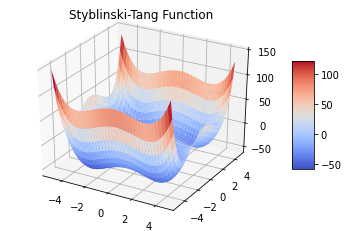

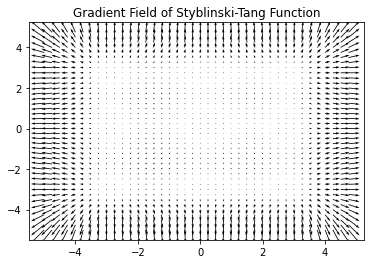

In [ ]:
plotFunction(name = 'Styblinski-Tang Function', function = STFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Styblinski-Tang Function', deriv_function = STDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [ ]:
batch_samples = genData(
                        function = STFunction, 
                        deriv_function = STDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = STFunction, 
                        deriv_function = STDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **1.1) Normal Training**

In [ ]:
with_derivative = False
name_function = 'Styblinski-Tang Function normal training'
name_grad = 'Gradient Field of Styblinski-Tang Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **1.2) Sobolev Training**

In [ ]:
with_derivative = True
name_function = 'Styblinski-Tang Function  sobolev training'
name_grad = 'Gradient Field of Styblinski-Tang Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **1.3) Siren**

In [ ]:
## **1.3) Siren**
with_derivative = True
name_function = 'Styblinski-Tang Function Siren'
name_grad = 'Gradient Field of Styblinski-Tang Function Siren'

model_kwargs.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs,  with_derivative, name_function, name_grad)

## **1.4) Differential ML**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 627.71234
standard_dyloss : 1281.6351
differential_yloss : 363.60663
differential_dyloss : 956.8037
[[627.71234], [1281.6351], [363.60663], [956.8037]]


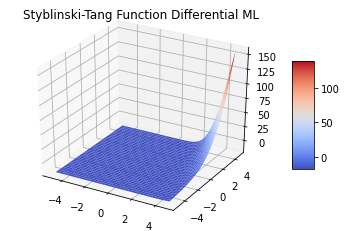

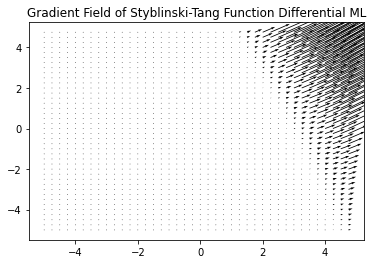

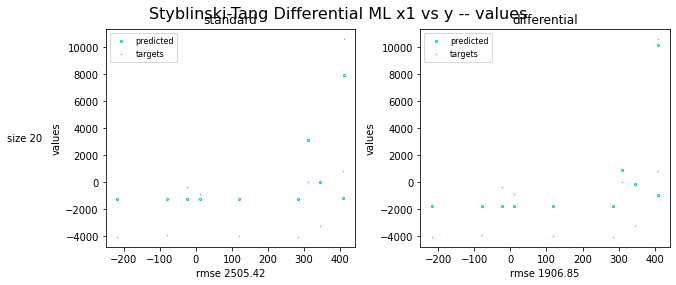

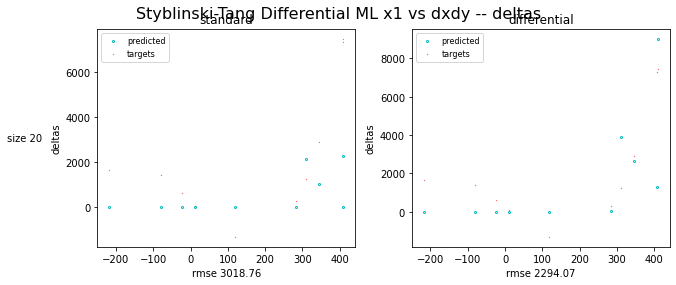

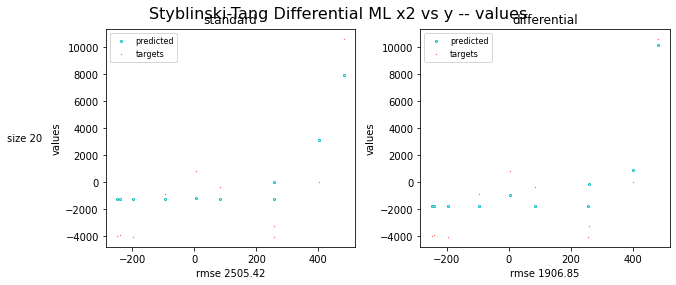

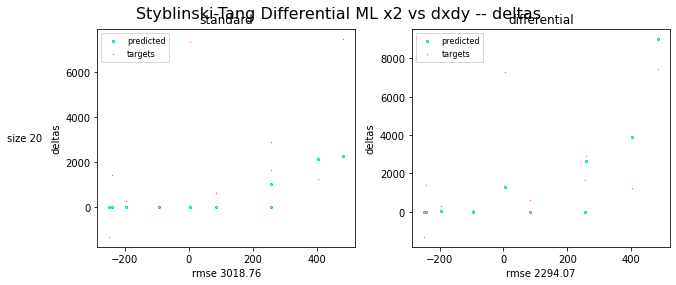

In [ ]:
generator = Generator(callable_function = STFunction, callable_function_deriv = STDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Styblinski-Tang Differential ML"
name_function = 'Styblinski-Tang Function Differential ML'
name_grad = 'Gradient Field of Styblinski-Tang Function Differential ML'

regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

## **1.5) twin_net with siren**

In [ ]:
with_derivative = True      
name_function = 'Styblinski-Tang Function Twin_net & Siren'
name_grad = 'Gradient Field of Styblinski-Tang Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **1.6) twin_net with MLP**

In [ ]:
with_derivative = True      
name_function = 'Styblinski-Tang Function Twin_net & MLP'
name_grad = 'Gradient Field of Styblinski-Tang Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **2) Ackley function** : http://www.sfu.ca/~ssurjano/ackley.html 


**Recommended variable values are: a=20, b=0.2 and c=2π**

In [ ]:
min_x = -5
max_x = 5
step_x = 0.25 
min_y = -5
max_y = 5
step_y = 0.25

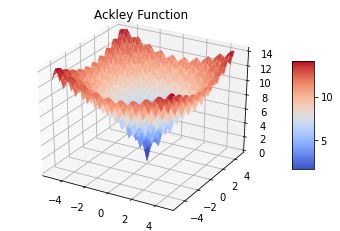

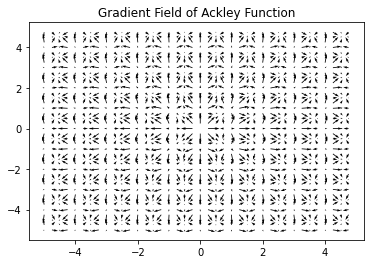

In [ ]:
plotFunction(name = 'Ackley Function', function = AckleyFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Ackley Function', deriv_function = AckleyDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [ ]:
batch_samples = genData(
                        function = AckleyFunction, 
                        deriv_function = AckleyDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = AckleyFunction, 
                        deriv_function = AckleyDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **2.1) Normal Training**

In [ ]:
with_derivative = False
name_function = 'Ackley Function normal training'
name_grad = 'Gradient Field of Ackley Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **2.2) Sobolov Training**

In [ ]:
with_derivative = True
name_function = 'Ackley Function  sobolev training'
name_grad = 'Gradient Field of Ackley Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **2.3) Siren**

In [ ]:
with_derivative = True
name_function = 'Ackley Function Siren'
name_grad = 'Gradient Field of Ackley Function Siren'

model_kwargs.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs,  with_derivative, name_function, name_grad)

## **2.4) Differential ML**

In [ ]:
generator = Generator(callable_function = AckleyFunction, callable_function_deriv = AckleyDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Ackley Differential ML"
name_function = 'Ackley Function Differential ML'
name_grad = 'Gradient Field of Ackley Function Differential ML'

regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

## **2.5) twin_net with siren**

In [ ]:
with_derivative = True      
name_function = 'Ackley Function Twin_net & Siren'
name_grad = 'Gradient Field of Ackley Function Twin_net & Siren'

twinNet, test_loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **2.6) twin_net with MLP**

In [ ]:
with_derivative = True      
name_function = 'Ackley Function Twin_net & MLP'
name_grad = 'Gradient Field of Ackley Function Twin_net & MLP'

twinNet, test_loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **3) Beale function** : https://www.sfu.ca/~ssurjano/beale.html


In [ ]:
min_x = -4.5
max_x = 4.5
step_x = 0.25
min_y = -4.5
max_y = 4.5
step_y = 0.25

In [ ]:
plotFunction(name = 'Beale Function', function = BealeFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Beale Function', deriv_function = BealeDeriv, 
            min_x = min_x, max_x = max_x, step_x = step_x, 
            min_y = min_y, max_y = max_y, step_y = step_y)

In [ ]:
batch_samples = genData(
                        function = BealeFunction, 
                        deriv_function = BealeDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = BealeFunction, 
                        deriv_function = BealeDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **3.1) Normal Training**

In [ ]:
with_derivative = False
name_function = 'Beale Function normal training'
name_grad = 'Gradient Field of Beale Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **3.2) Sobolev Training**

In [ ]:
with_derivative = True
name_function = 'Beale Function  sobolev training'
name_grad = 'Gradient Field of Beale Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **3.3) Siren**

In [ ]:
with_derivative = True
name_function = 'Beale Function Siren'
name_grad = 'Gradient Field of Beale Function Siren'

model_kwargs.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs,  with_derivative, name_function, name_grad)

## **3.4) Differential ML**

In [ ]:
generator = Generator(callable_function = BealeFunction, callable_function_deriv = BealeDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Beale Differential ML"
name_function = 'Beale Function Differential ML'
name_grad = 'Gradient Field of Beale Function Differential ML'

regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

## **3.5) twin_net with siren**

In [ ]:
with_derivative = True      
name_function = 'Beale Function Twin_net & Siren'
name_grad = 'Gradient Field of Beale Function Twin_net & Siren'

twinNet, test_loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **3.6) twin_net with MLP**

In [ ]:
with_derivative = True      
name_function = 'Beale Function Twin_net & MLP'
name_grad = 'Gradient Field of Beale Function Twin_net & MLP'

twinNet, test_loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **4) Booth function** : https://www.sfu.ca/~ssurjano/booth.html

In [ ]:
min_x = -10 
max_x = 10
step_x = 0.25
min_y = -10
max_y = 10
step_y = 0.25

In [ ]:
plotFunction(name = 'Booth Function', function = BoothFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Booth Function', deriv_function = BoothDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [ ]:
batch_samples = genData(
                        function = BoothFunction, 
                        deriv_function = BoothDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = BoothFunction, 
                        deriv_function = BoothDeriv,
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **4.1) Normal Training**

In [ ]:
with_derivative = False
name_function = 'Booth Function normal training'
name_grad = 'Gradient Field of Booth Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **4.2) Sobolev Training**

In [ ]:
with_derivative = False
name_function = 'Booth Function  sobolev training'
name_grad = 'Gradient Field of Booth Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **4.3) Siren**

In [ ]:
with_derivative = True
name_function = 'Booth Function Siren'
name_grad = 'Gradient Field of Booth Function Siren'

model_kwargs.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs,  with_derivative, name_function, name_grad)

## **4.4) Differential ML**

In [ ]:
generator = Generator(callable_function = BoothFunction, callable_function_deriv = BoothDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Booth Differential ML"
name_function = 'Booth Function Differential ML'
name_grad = 'Gradient Field of Booth Function Differential ML'

regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

## **4.5) twin_net with siren**

In [ ]:
with_derivative = True      
name_function = 'Booth Function Twin_net & Siren'
name_grad = 'Gradient Field of Booth Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **4.6) twin_net with MLP**

In [ ]:
with_derivative = True      
name_function = 'Booth Function Twin_net & MLP'
name_grad = 'Gradient Field of Booth Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **5) Bukin function** : https://www.sfu.ca/~ssurjano/bukin6.html


In [ ]:
min_x = -15
max_x = -5
step_x = 0.25
min_y = -3
max_y = 3
step_y = 0.25

In [ ]:
plotFunction(name = 'Bukin Function', function = BukinFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Bukin Function', deriv_function = BukinDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [ ]:
batch_samples = genData(
                        function = BukinFunction, 
                        deriv_function = BukinDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = BukinFunction, 
                        deriv_function = BukinDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **5.1) Normal Training**

In [ ]:
with_derivative = False
name_function = 'Bukin Function normal training'
name_grad = 'Gradient Field of Bukin Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **5.2) Sobolev Training**

In [ ]:
with_derivative = True
name_function = 'Bukin Function normal training'
name_grad = 'Gradient Field of Bukin Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **5.3) Siren**

In [ ]:
with_derivative = True
name_function = 'Bukin Function Siren'
name_grad = 'Gradient Field of Bukin Function Siren'

model_kwargs.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs,  with_derivative, name_function, name_grad)

## **5.4) Differential ML**

In [ ]:
generator = Generator(callable_function = BukinFunction, callable_function_deriv = BukinDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Bukin Differential ML"
name_function = 'Bukin Function Differential ML'
name_grad = 'Gradient Field of Bukin Function Differential ML'

regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

## **5.5) twin_net with siren**

In [ ]:
with_derivative = True      
name_function = 'Bukin Function Twin_net & Siren'
name_grad = 'Gradient Field of Bukin Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **5.6) twin_net with MLP**

In [ ]:
with_derivative = True      
name_function = 'Bukin Function Twin_net & MLP'
name_grad = 'Gradient Field of Bukin Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **6) McCormick function** : https://www.sfu.ca/~ssurjano/mccorm.html

In [ ]:
min_x = -1.5
max_x = 4
step_x = 0.25
min_y = -3
max_y = 4
step_y = 0.25

In [ ]:
plotFunction(name = 'McCormick Function', function = McCormickFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of McCormick Function', deriv_function = McCormickDeriv, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

In [ ]:
batch_samples = genData(
                        function = McCormickFunction, 
                        deriv_function = McCormickDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = McCormickFunction, 
                        deriv_function = McCormickDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **6.1) Normal Training**

In [ ]:
with_derivative = False
name_function = 'McCormick Function normal training'
name_grad = 'Gradient Field of McCormick Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **6.2) Sobolev Training**

In [ ]:
with_derivative = False
name_function = 'McCormick Function  sobolev training'
name_grad = 'Gradient Field of McCormick Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **6.3) Siren**

In [ ]:
with_derivative = True
name_function = 'McCormick Function Siren'
name_grad = 'Gradient Field of McCormick Function Siren'

model_kwargs.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs,  with_derivative, name_function, name_grad)

## **6.4) Differential ML**

In [ ]:
generator = Generator(callable_function = McCormickFunction, callable_function_deriv = McCormickDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "McCormick Differential ML"
name_function = 'McCormick Function Differential ML'
name_grad = 'Gradient Field of McCormick Function Differential ML'

regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

## **6.5) twin_net with siren**

In [ ]:
with_derivative = True      
name_function = 'McCormick Function Twin_net & Siren'
name_grad = 'Gradient Field of McCormick Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **6.6) twin_net with MLP**

In [ ]:
with_derivative = True      
name_function = 'McCormick Function Twin_net & MLP'
name_grad = 'Gradient Field of McCormick Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **7) Rosenbrock function** : https://www.sfu.ca/~ssurjano/mccorm.html

In [ ]:
min_x = -2 
max_x = 2
step_x = 0.25
min_y = -2 
max_y = 2 
step_y = 0.25

In [ ]:
plotFunction(name = 'Rosenbrock Function', function = RosenbrockFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Rosenbrock Function', deriv_function = RosenbrockDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [ ]:
batch_samples = genData(
                        function = RosenbrockFunction, 
                        deriv_function = RosenbrockDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = RosenbrockFunction, 
                        deriv_function = RosenbrockDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **7.1) Normal Training**

In [ ]:
with_derivative = False
name_function = 'Rosenbrock Function normal training'
name_grad = 'Gradient Field of Rosenbrock Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **7.2) Sobolev Training**

In [ ]:
with_derivative = True
name_function = 'Rosenbrock Function  sobolev training'
name_grad = 'Gradient Field of Rosenbrock Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **7.3) Siren**

In [ ]:
with_derivative = True
name_function = 'Rosenbrock Function Siren'
name_grad = 'Gradient Field of Rosenbrock Function Siren'

model_kwargs.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs,  with_derivative, name_function, name_grad)

## **7.4) Differential ML**

In [ ]:
generator = Generator(callable_function = RosenbrockFunction, callable_function_deriv = RosenbrockDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Rosenbrock Differential ML"
name_function = 'Rosenbrock Function Differential ML'
name_grad = 'Gradient Field of Rosenbrock Function Differential ML'

regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

## **1.5) twin_net with siren**

In [ ]:
with_derivative = True      
name_function = 'Rosenbrock Function Twin_net & Siren'
name_grad = 'Gradient Field of Rosenbrock Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **7.6) twin_net with MLP**

In [ ]:
with_derivative = True      
name_function = 'Rosenbrock Function Twin_net & MLP'
name_grad = 'Gradient Field of Rosenbrock Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

#**8) End**